In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%pip install torch
%pip install kaggle
%pip install torchvision
%pip install scikit-image
%pip install numpy

# Dataset Preparation

In [ ]:
!kaggle datasets download -d requiemonk/sentinel12-image-pairs-segregated-by-terrain

Dataset URL: https://www.kaggle.com/datasets/requiemonk/sentinel12-image-pairs-segregated-by-terrain
License(s): Attribution 4.0 International (CC BY 4.0)
100% 2.54G/2.55G [02:02<00:00, 23.6MB/s]
100% 2.55G/2.55G [02:02<00:00, 22.3MB/s]


In [ ]:
%%capture
!unzip sentinel12-image-pairs-segregated-by-terrain.zip
!rm -rf sentinel12-image-pairs-segregated-by-terrain.zip

In [ ]:
import os
opt = []
sar = []
root_dir = './v_2'
for dir in os.listdir(root_dir):
  path = os.path.join(root_dir, dir)
  s1, s2  = os.listdir(path)
  if s1 == 's2':
    print(s1)
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s2, file))
  if s1 == 's1':
    for file in os.listdir(os.path.join(path, s1)):
      if file.endswith('.png'):
        sar.append(os.path.join(path, s1, file))
    for file in os.listdir(os.path.join(path, s2)):
      if file.endswith('.png'):
        opt.append(os.path.join(path, s2, file))
opt = sorted(opt)
sar = sorted(sar)
print(len(opt), len(sar))


16000 16000


# **Implementing Colorization Model**

In [ ]:
import cv2
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt



## Preparing dataset for colorization model

In [ ]:
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb

def rgb_to_lab(img):

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)
    L_channel = img_lab[[0], ...]
    ab_channels = img_lab[[1, 2], ...]
    # scale between -1 to 1
    L_channel = 2 * (L_channel - (0)) / (100 - (0)) - 1
    ab_channels = 2 * (ab_channels - (-128)) / (127 - (-128)) - 1

    return L_channel, ab_channels

In [ ]:
def create_patches(img, patch_size=224):
    patches = []
    h, w = img.shape[1:]

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[:, i:i + patch_size, j:j + patch_size]
            if patch.shape[1:] == (patch_size, patch_size):
                patches.append(patch)

    return patches

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, color_dir, transform=None, patch_size=224):
        self.color_dir = color_dir
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.color_dir)

    def __getitem__(self, idx):

        color_img = np.array(Image.open(self.color_dir[idx]))
        color_img = cv2.resize(color_img, (224, 224))

        # Convert to Lab color space
        L_channel, ab_channels = rgb_to_lab(color_img)

        return L_channel, ab_channels

In [ ]:
dataset = ColorizationDataset(opt[:10000])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)


In [ ]:
# Load a batch and print the shapes of the patches
for L_patches, ab_patches in train_loader:
    print(f"L_patches shape: {L_patches.shape}")
    print(f"ab_patches shape: {ab_patches.shape}")
    print(L_patches[0])
    break

L_patches shape: torch.Size([8, 1, 224, 224])
ab_patches shape: torch.Size([8, 2, 224, 224])
tensor([[[ 0.5341,  0.5169,  0.4498,  ...,  0.2615,  0.0825, -0.1028],
         [ 0.5010,  0.4903,  0.4669,  ...,  0.2760,  0.0744,  0.0189],
         [ 0.4175,  0.4319,  0.5260,  ...,  0.3283,  0.2022,  0.1088],
         ...,
         [-0.2206, -0.2102, -0.2375,  ..., -0.5997, -0.5729, -0.5271],
         [-0.1863, -0.1880, -0.2322,  ..., -0.5546, -0.5179, -0.5104],
         [-0.0443, -0.0652, -0.2037,  ..., -0.5435, -0.5321, -0.5267]]])


## Implementing the Encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights, DenseNet121_Weights

class EnsembleEncoder(nn.Module):
    def __init__(self):
        super(EnsembleEncoder, self).__init__()

        # Load pre-trained ResNet50 and DenseNet121
        self.resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.densenet121 = models.densenet121(weights=DenseNet121_Weights.DEFAULT)

        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-2])
        # self.densenet121 = nn.Sequential(*list(self.densenet121.children())[:-1])
        self.densenet121.classifier = nn.Identity()


        # Custom layers for fusion
        self.conv1x1_resnet50 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(2048, 1024, kernel_size=1)
        ])

        self.conv1x1_densenet121 = nn.ModuleList([
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.Conv2d(1024, 1024, kernel_size=1)
        ])

        self.fusion_blocks = nn.ModuleList([
            self.fusion_block(128, 128),
            self.fusion_block(256, 256),
            self.fusion_block(512, 512),
            self.fusion_block(1024, 1024)
        ])

    # Fusion block
    def fusion_block(self, in_channels_resnet, in_channels_densenet):
        return nn.Sequential(
            nn.Conv2d(in_channels_resnet + in_channels_densenet, in_channels_resnet, kernel_size=1),
            nn.BatchNorm2d(in_channels_resnet),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Forward pass through ResNet50
        resnet_features = []
        resnet_input = x
        for i, layer in enumerate(self.resnet50.children()):
            resnet_input = layer(resnet_input)
            if i in [4, 5, 6, 7]:  # Extract features after specific layers
                resnet_features.append(self.conv1x1_resnet50[i-4](resnet_input))

        # Forward pass through DenseNet121
        densenet_features = []
        idx = 0
        densenet_input = x
        for i, layer in enumerate(self.densenet121.features):
            densenet_input = layer(densenet_input)
            if i in [ 4, 6, 8, 11]:
                densenet_features.append(self.conv1x1_densenet121[idx](densenet_input))
                idx += 1


        fused_features = []
        for i in range(4):
            fused = torch.cat((resnet_features[i], densenet_features[i]), dim=1)
            fused = self.fusion_blocks[i](fused)
            fused_features.append(fused)

        return fused_features


## Implementing the Decoder

In [ ]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Decoder block 1: Takes input from Fusion Block 4
        self.decode1 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 7x7 -> 14x14
        )

        # Decoder block 2: Takes input from Decoder Block 1 + Fusion Block 3 (512 + 512 channels)
        self.decode2 = nn.Sequential(
            nn.Conv2d(512 + 512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 14x14 -> 28x28
        )

        # Decoder block 3: Takes input from Decoder Block 2 + Fusion Block 2 (256 + 256 channels)
        self.decode3 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 28x28 -> 56x56
        )

        # Decoder block 4: Takes input from Decoder Block 3 + Fusion Block 1 (128 + 128 channels)
        self.decode4 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 56x56 -> 112x112
        )

        # Final decoder block: Reduce to 2 channels (ab channels)
        self.decode5 = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),            
            nn.BatchNorm2d(2),            
            nn.Tanh(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)  # 112x112 -> 224x224
        )

    def forward(self, features_7x7, features_14x14, features_28x28, features_56x56):
        x = self.decode1(features_7x7)
        x = torch.cat([x, features_14x14], dim=1)
        x = self.decode2(x)

        x = torch.cat([x, features_28x28], dim=1)
        x = self.decode3(x)

        x = torch.cat([x, features_56x56], dim=1)
        x = self.decode4(x)

        output = self.decode5(x)

        return output


## Checking our model

In [ ]:
import torch
import torch.nn as nn

class ColorizationModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ColorizationModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        features_56x56, features_28x28, features_14x14, features_7x7 = self.encoder(x)

        output = self.decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        return output

encoder = EnsembleEncoder().to(device)
decoder = Decoder().to(device)

model = ColorizationModel(encoder, decoder)

# input data
L_patches = torch.randn(1, 3, 224, 224).to(device)

output = model(L_patches)

print("Output shape:", output.shape)  # output shape should be [1, 2, 224, 224]


Output shape: torch.Size([1, 2, 224, 224])


## Training the model

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = EnsembleEncoder().to(device)
decoder = Decoder().to(device)

# Freeze the encoder parameters as they are pre-trained
for param in encoder.parameters():
    param.requires_grad = False

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    encoder.eval()
    decoder.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)")
    for i, (L_batch, ab_batch) in enumerate(train_bar):
        L, ab = L_batch.to(device), ab_batch.to(device)
        L = L.repeat(1, 3, 1, 1)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
        output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

        # Compute loss
        loss = criterion(output, ab)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

        # Update progress bar
        train_bar.set_postfix(loss=f"{running_loss/(i+1):.4f}")

    # Validation phase
    decoder.eval()
    val_loss = 0.0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")
    with torch.no_grad():
        for i, (L_batch, ab_batch) in enumerate(val_bar):
            L, ab = L_batch.to(device), ab_batch.to(device)
            L = L.repeat(1, 3, 1, 1)  

            # Forward pass
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L)
            output = decoder(features_7x7, features_14x14, features_28x28, features_56x56)

            # Compute validation loss
            loss = criterion(output, ab)
            val_loss += loss.item()

            val_bar.set_postfix(loss=f"{val_loss/(i+1):.4f}")

    # Calculate average losses
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(decoder.state_dict(), 'model_1.pth')
        print(f"Model saved with validation loss: {best_val_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_val_loss)

print("Training complete.")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.79it/s, loss=0.0137]


Epoch 1/20, Training Loss: 0.0331, Validation Loss: 0.0137
Model saved with validation loss: 0.0137


Epoch 2/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.13it/s, loss=0.0126]


Epoch 2/20, Training Loss: 0.0191, Validation Loss: 0.0126
Model saved with validation loss: 0.0126


Epoch 3/20 (Validation): 100%|██████████| 200/200 [00:22<00:00,  9.00it/s, loss=0.0061]


Epoch 3/20, Training Loss: 0.0116, Validation Loss: 0.0061
Model saved with validation loss: 0.0061


Epoch 4/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.73it/s, loss=0.0041]


Epoch 4/20, Training Loss: 0.0055, Validation Loss: 0.0041
Model saved with validation loss: 0.0041


Epoch 5/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.92it/s, loss=0.0038]


Epoch 5/20, Training Loss: 0.0048, Validation Loss: 0.0038
Model saved with validation loss: 0.0038


Epoch 6/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.53it/s, loss=0.0037]


Epoch 6/20, Training Loss: 0.0046, Validation Loss: 0.0037
Model saved with validation loss: 0.0037


Epoch 7/20 (Validation): 100%|██████████| 200/200 [00:22<00:00,  8.91it/s, loss=0.0034]


Epoch 7/20, Training Loss: 0.0044, Validation Loss: 0.0034
Model saved with validation loss: 0.0034


Epoch 8/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.30it/s, loss=0.0037]


Epoch 8/20, Training Loss: 0.0044, Validation Loss: 0.0037


Epoch 9/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.83it/s, loss=0.0033]


Epoch 9/20, Training Loss: 0.0042, Validation Loss: 0.0033
Model saved with validation loss: 0.0033


Epoch 10/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.54it/s, loss=0.0036]


Epoch 10/20, Training Loss: 0.0041, Validation Loss: 0.0036


Epoch 11/20 (Validation): 100%|██████████| 200/200 [00:22<00:00,  8.80it/s, loss=0.0031]


Epoch 11/20, Training Loss: 0.0039, Validation Loss: 0.0031
Model saved with validation loss: 0.0031


Epoch 12/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.69it/s, loss=0.0031]


Epoch 12/20, Training Loss: 0.0039, Validation Loss: 0.0031


Epoch 13/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.68it/s, loss=0.0030]


Epoch 13/20, Training Loss: 0.0038, Validation Loss: 0.0030
Model saved with validation loss: 0.0030


Epoch 14/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.33it/s, loss=0.0029]


Epoch 14/20, Training Loss: 0.0036, Validation Loss: 0.0029
Model saved with validation loss: 0.0029


Epoch 15/20 (Validation): 100%|██████████| 200/200 [00:22<00:00,  9.05it/s, loss=0.0032]


Epoch 15/20, Training Loss: 0.0035, Validation Loss: 0.0032


Epoch 16/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.62it/s, loss=0.0028]


Epoch 16/20, Training Loss: 0.0033, Validation Loss: 0.0028
Model saved with validation loss: 0.0028


Epoch 17/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.32it/s, loss=0.0027]


Epoch 17/20, Training Loss: 0.0033, Validation Loss: 0.0027
Model saved with validation loss: 0.0027


Epoch 18/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.20it/s, loss=0.0026]


Epoch 18/20, Training Loss: 0.0031, Validation Loss: 0.0026
Model saved with validation loss: 0.0026


Epoch 19/20 (Validation): 100%|██████████| 200/200 [00:20<00:00,  9.61it/s, loss=0.0026]


Epoch 19/20, Training Loss: 0.0031, Validation Loss: 0.0026
Model saved with validation loss: 0.0026


Epoch 20/20 (Validation): 100%|██████████| 200/200 [00:21<00:00,  9.29it/s, loss=0.0026]


Epoch 20/20, Training Loss: 0.0030, Validation Loss: 0.0026
Model saved with validation loss: 0.0026
Training complete.


In [ ]:
torch.cuda.empty_cache()

## Load the model

In [ ]:
decoder = Decoder().to(device)
decoder.load_state_dict(torch.load('model_1.pth', map_location=device))

<ipython-input-31-279d8c970859>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  decoder.load_state_dict(torch.load('model_1.pth', map_location=device))


<All keys matched successfully>

## Inference

In [ ]:
# Get a batch from the test loader
dataiter = iter(test_loader)
L_batch, ab_batch = next(dataiter)
L_batch, ab_batch = next(dataiter)
L_batch, ab_batch = L_batch.to(device), ab_batch.to(device)
L_batch = L_batch.repeat(1, 3, 1, 1)

encoder.eval()
decoder.eval()
with torch.no_grad():
    features_56x56, features_28x28, features_14x14, features_7x7 = encoder(L_batch)

    predicted_ab = decoder(features_7x7, features_14x14, features_28x28, features_56x56)


In [ ]:
L_batch = L_batch[:, 0, :, :]
L_batch = L_batch.unsqueeze(1)

L_batch = (L_batch + 1) * 0.5 * 100
predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

# Combine L and ab channels
predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
real_lab = torch.cat([L_batch, ab_batch], dim=1)


predicted_lab = predicted_lab.cpu().numpy()
real_lab = real_lab.cpu().numpy()

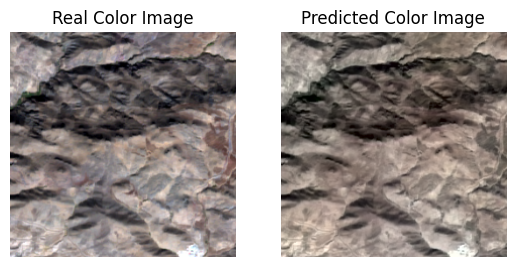

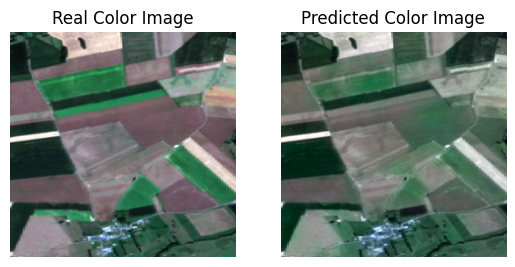

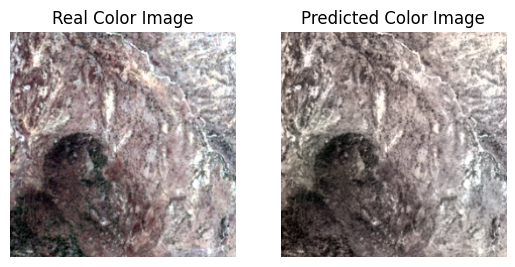

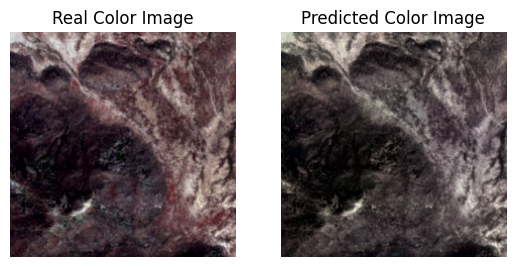

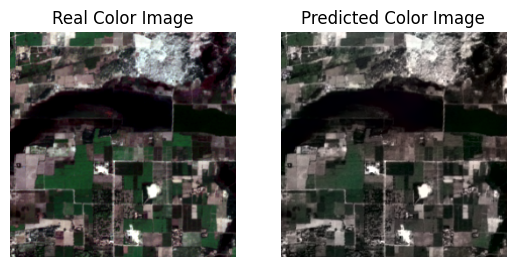

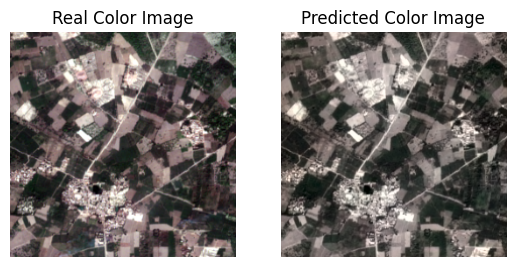

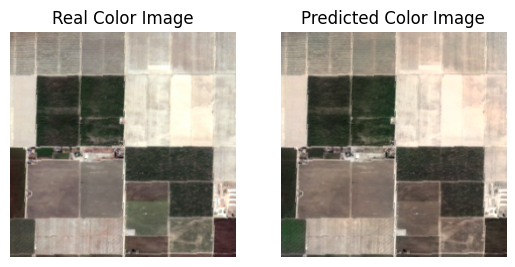

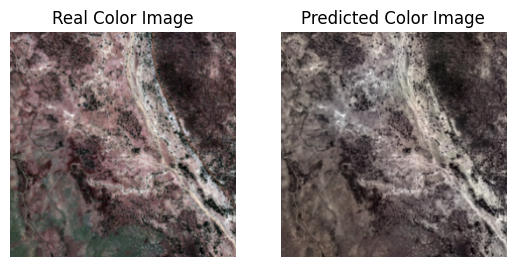

In [ ]:
import numpy as np
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import cv2


# Iterate over the batch
for i in range(8):

    lab_image = predicted_lab[i]
    real_img = real_lab[i]

    # Transpose to (height, width, 3) for skimage
    lab_image = lab_image.transpose(1, 2, 0).astype(np.float64)
    real_img = real_img.transpose(1, 2, 0).astype(np.float64)

    rgb_image = lab2rgb(lab_image)
    real_rgb = lab2rgb(real_img)

    plt.subplot(1, 2, 1)
    plt.imshow(real_rgb)
    plt.axis('off')
    plt.title('Real Color Image')
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_image)
    plt.title('Predicted Color Image')
    plt.axis('off')
    plt.show()


## Evaulting the Model

In [ ]:
def prediction(model, test_loader):
    encoder.eval()
    model.eval()
    original_images = []
    predicted_images = []

    for L_batch, ab_batch in tqdm(test_loader):
        L_batch, ab_batch = L_batch.to(device), ab_batch.to(device)
        input = L_batch.repeat(1, 3, 1, 1)

        with torch.no_grad():
            features_56x56, features_28x28, features_14x14, features_7x7 = encoder(input)

            predicted_ab = model(features_7x7, features_14x14, features_28x28, features_56x56)            

        L_batch = (L_batch + 1) * 0.5 * 100        
        predicted_ab = ((predicted_ab + 1) * 0.5 * (127 + 128)) - 128
        ab_batch = ((ab_batch + 1) * 0.5 * (127 + 128)) - 128

        # Combine L and ab channels
        predicted_lab = torch.cat([L_batch, predicted_ab], dim=1)
        actual_lab = torch.cat([L_batch, ab_batch], dim=1)

        predicted_lab = predicted_lab.cpu().numpy()
        actual_lab = actual_lab.cpu().numpy()

        predicted_images.extend(predicted_lab)
        original_images.extend(actual_lab)

    return original_images, predicted_images

original_images, predicted_images = prediction(decoder, test_loader)

100%|██████████| 250/250 [00:30<00:00,  8.32it/s]


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.color import lab2rgb
import numpy as np

def evaluate_model(original_images, predicted_images):

    total_ssim = 0.0
    total_psnr = 0.0
    total_samples = 0
    for original_img, predicted_img in zip(original_images, predicted_images):
        original_img = lab2rgb(original_img.transpose(1, 2, 0))
        predicted_img = lab2rgb(predicted_img.transpose(1, 2, 0))

        ssim_value = ssim(original_img, predicted_img, multichannel=True, channel_axis=2, data_range=1.0)
        psnr_value = psnr(original_img, predicted_img, data_range=1.0)
        total_ssim += ssim_value
        total_psnr += psnr_value
        total_samples += 1

    average_ssim = total_ssim / total_samples
    average_psnr = total_psnr / total_samples

    return average_ssim, average_psnr

ssim_value, psnr_value = evaluate_model(original_images, predicted_images)
print(f"Average SSIM: {ssim_value:.4f}")
print(f"Average PSNR: {psnr_value:.4f}")



Average SSIM: 0.9400
Average PSNR: 29.9230


# Results

We are getting quite good results but after observing carefully we saw that the model is learning green color more than the other colors.